## Large Scale Optimization TP1:

#### Samuel Bazaz Jazayeri

In [11]:
pip install pywt

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement pywt (from versions: none)
ERROR: No matching distribution found for pywt


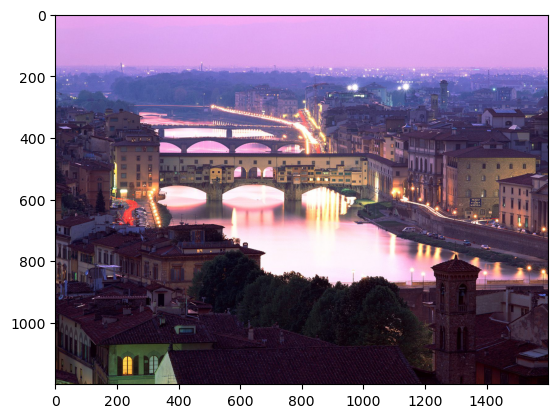

In [78]:
############
# Packages #
############
import os
import sys
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pywt
from pathlib import Path
from skimage import io

root_path = Path.cwd().parents[0]
sys.path.insert(0, str(root_path))

img_path = root_path.joinpath("image_denoizing", "florence.jpg")
img0 = io.imread(img_path)

plt.imshow(img0)

#### Add noise

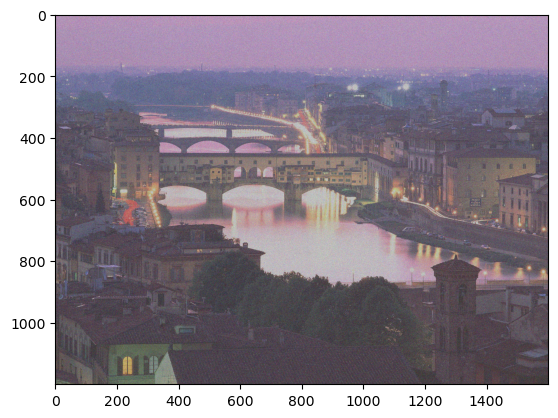

In [79]:
gaussian_noise = np.random.normal(0, 30, img.shape) 

noised_img = img0 + gaussian_noise
# noised_img = np.clip(noised_img, 0, 255) 

cv2.normalize(noised_img, noised_img, 0, 255, cv2.NORM_MINMAX, dtype=-1)
noised_img = noised_img.astype(np.uint8)

plt.imshow(noised_img)

#### Test Wavelet transforme and inverse transform

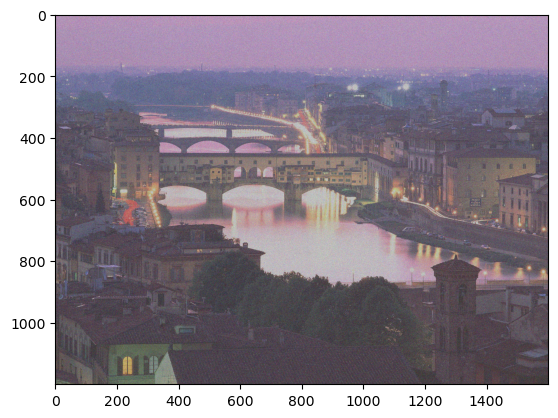

In [80]:
pwt = pywt.WaveletPacket2D(data=noised_img, wavelet='db1', mode='symmetric')
plt.imshow(pwt.reconstruct(update=False))

### Create pipeline for dénoising

- Transforme
- implement choosen proxymal function on every coefficient
- Inverse Transforme
- recover RGB format

In [81]:
def get_power_q_proxymal(ki,q):
    f = None
    if q==1:
        def f(x):
            return max(abs(x)-ki, 0)*np.sign(x)
    if q==4/3:
        def f(x):
            eps = np.sqrt(x**2+256*(ki**3)/729)
            c = (4*ki)/(3*(2**(1/3)))
            return x+c*((eps-x)**(1/3)-(eps+x)**(1/3))
        
    if q==2/3:
        def f(x):
            ki2 = ki**2
            m = np.prod([
                9*ki2*np.sign(x)/8,
                1-np.sqrt(1+(16*np.abs(x))/(9*ki2))
            ])
            return x+m
    if q==2:
        def f(x):
            return x/(1+2*ki)
    if q==3:
        def f(x):
            return np.prod([
                np.sign(x),
                1/(6*ki),
                np.sqrt(1+12*ki*np.abs(x))-1
            ])
    if q==4:
        def f(x):
            eps = np.sqrt(ki**2+1/(27*ki))
            f_aux = lambda k: ((eps+k)/(8*ki))**(1/3)
            return f_aux(x)-f_aux(-x)
    if f:
        f = np.vectorize(f)
        return f

for q in [1,4/3,2/3,2,3,4]:
    print(f"q={np.round(q,3)}:",get_power_q_proxymal(1,q)(1))

q=1: 0
q=1.333: 0.20888376352820393
q=0.667: 0.2499999999999999
q=2: 0.3333333333333333
q=3: 0.4342585459106648
q=4: 0.4999999999999999


In [97]:
def apply_to_wavelet(pwt, vecf = get_power_q_proxymal(1,1), max_depth=None):
    lst = [n.path for n in pwt.get_leaf_nodes()]
    pwt2 = pwt
    for path in lst:
        print(path)
        if max_depth:
            if len(path)>max_depth:
                pwt2[path].data = 0
            else:
                pwt2[path].data = vecf(pwt[path].data)
        else:
            pwt2[path].data = vecf(pwt[path].data)
    return pwt2

def recover_rgb_format(img):
    return np.clip(img, a_min = 0, a_max = 255).astype(int)

def img_from_wavelet(pwt):
    img = np.clip(pwt.reconstruct(update=False), a_min = 0, a_max = 255)
    return img.astype(int)

def realigne_luminosity(img_denoised,img):
    return (img_denoised/np.sum(img_denoised))*np.sum(img)

def wavelet_to_proxf(noised_img,ki,q, max_depth=2):
    pwt = pywt.WaveletPacket2D(data=noised_img, wavelet='db1', mode='symmetric')
    pwt2 = apply_to_wavelet(pwt, vecf = get_power_q_proxymal(ki,q), max_depth=max_depth )
    img_denoised = img_from_wavelet(pwt2)
#     img_denoised = realigne_luminosity(img_denoised,img0)
    return  recover_rgb_format(img_denoised)

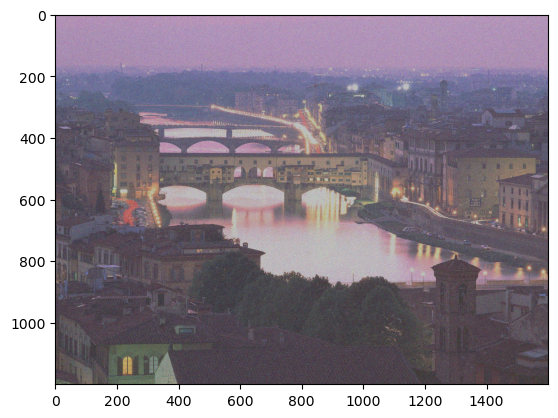

In [98]:
plt.imshow(wavelet_to_proxf(noised_img,0.1,4/3,max_depth=None))

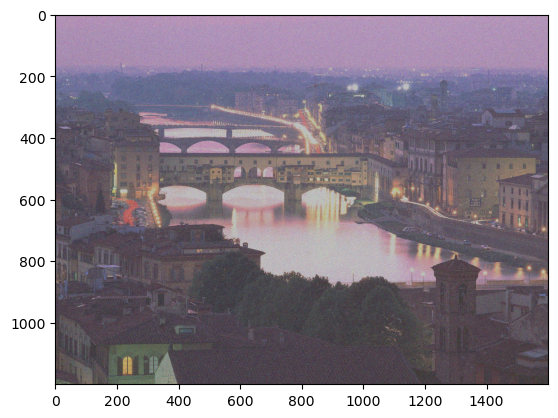

In [89]:
plt.imshow(wavelet_to_proxf(noised_img,0.1,4/3,max_depth=1))

### Fine tuning

In [90]:
def get_florence_mse(img0,noised_img,ki,q):
    img_denoised = wavelet_to_proxf(noised_img,ki,q,max_depth=None)
    return np.linalg.norm(img0-img_denoised)

get_florence_mse(img0,0.1,4/3)

102612.66335106989

In [93]:
get_losse = lambda lst: get_florence_mse(img0,noised_img,lst[0],lst[1])

def fine_tune(lst_ki):
    ki_q = np.dstack(np.meshgrid(lst_ki, [1,4/3,2/3,2,3,4])).reshape(-1, 2)
    losses = np.apply_along_axis(get_losse, 1, ki_q) 
    print(losses)
    return ki_q[np.argmin(losses)]

print(fine_tune([0.01, 0.05, 0.1]+np.arange(0.2, 4, 0.2).tolist()))

C:\Users\samud\AppData\Local\Temp\ipykernel_19136\482862626.py:34: RuntimeWarning: overflow encountered in scalar negative
  return f_aux(x)-f_aux(-x)
C:\Users\samud\AppData\Local\Temp\ipykernel_19136\482862626.py:33: RuntimeWarning: invalid value encountered in scalar power
  f_aux = lambda k: ((eps+k)/(8*ki))**(1/3)
C:\Users\samud\AppData\Local\Temp\ipykernel_19136\1239397656.py:20: RuntimeWarning: invalid value encountered in cast
  return img.astype(int)























[102612.66335107 102612.66335107 102612.66335107 102612.66335107
 102612.66335107 102612.66335107 102612.66335107 102612.66335107
 102163.36914472 102163.36914472 102163.36914472 102163.36914472
 102163.36914472 101768.70466897 101768.70466897 101768.70466897
 101768.70466897 101768.70568598 101429.30772218 101429.30772218
 101429.30772218 101429.30772218 102612.66335107 102612.66335107
 102612.66335107 102207.86508875 102104.52656959 102214.80532193
 102103.35452374 102215.81767026 102304.00601638 102574.03482363
 102861.02891766 103289.97862329 103757.47701732 104302.78437319
 104938.24727905 105633.65314141 106393.71587176 107225.36575363
 108115.17209902 109047.89339093 110069.51868706 111092.20910127
 102612.66335107 102915.8786874  102472.85974833 102593.76109199
 102859.67018224 103697.04043028 104988.67733713 106708.37744526
 108780.40653537 111180.87829748 113809.521983   116679.51401167
 119695.77347593 122896.13556577 126160.83364499 129505.62814411
 132

In [94]:
get_florence_mse(img0,noised_img,3.2, 1.)

101429.30772217663

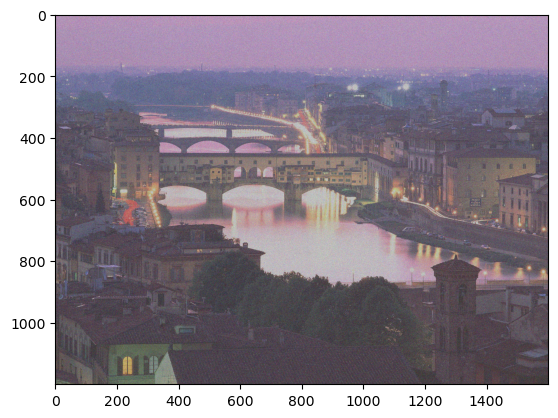

In [99]:
plt.imshow(noised_img)

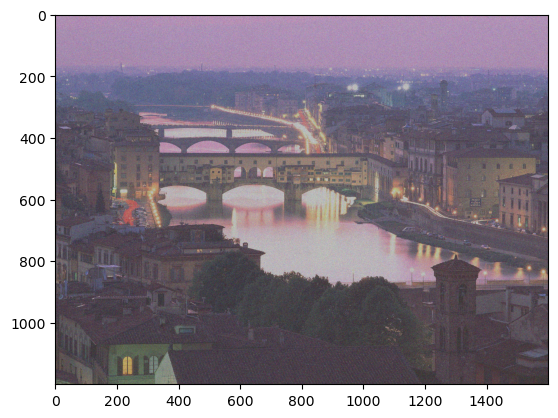

In [103]:
plt.imshow(wavelet_to_proxf(noised_img, 3.2, 1))

Pas vraiement concluant comme méthode 